In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.base import BaseEstimator, ClassifierMixin, RegressorMixin
from sklearn.model_selection import cross_validate
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix


In [93]:
# Load in cleaned data
df_train = pd.read_csv("train_df_clean.csv")
df_test = pd.read_csv("test_df_clean.csv")

# Load in cleaned data without normalization
# df_train_no_norm = pd.read_csv("train_df_clean_no_norm.csv")
# df_test_no_norm = pd.read_csv("test_df_clean_no_norm.csv")


# Section 1

## Q1:

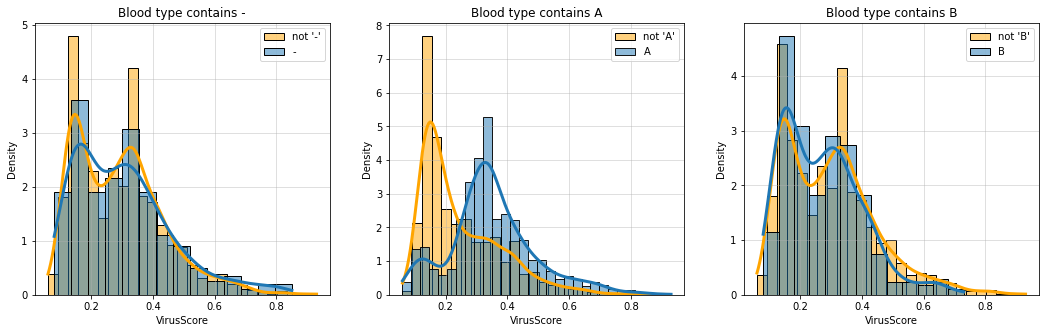

In [94]:
X_train = df_train.drop('VirusScore', axis=1)
y_train = df_train["VirusScore"]
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))
for i, cur_type in enumerate(['-', 'A', 'B']):
    filter_mask = X_train['blood_type'].str.contains(cur_type)
    sns.histplot(data=y_train[~filter_mask], ax=ax[i], stat="density", kde=True,
                 line_kws={"linewidth": 3}, color="orange", label="not '{}'".format(cur_type))
    sns.histplot(data=y_train[filter_mask], ax=ax[i], stat="density", kde=True,
                 line_kws={"linewidth": 3}, label=cur_type)
    ax[i].set_title("Blood type contains " + cur_type)
    ax[i].legend(), ax[i].grid(alpha=0.5)

In [95]:
# drop blood_type feature. No need to create new feature since already have it.

df_train.drop('blood_type', axis='columns', inplace=True)
df_test.drop('blood_type', axis='columns', inplace=True)

## post Q3:

In [96]:
#df_train_new = df_train.sample(frac=0.8, random_state=16)
#df_train_new_val = df_train.drop(df_train_new.index)

In [97]:
class LinearRegressor(BaseEstimator, RegressorMixin):
    """
    Custom linear regression model
    """
    def __init__(self, lr: float = 1e-5):
        """
        Initialize an instance of this class.
        ** Do not edit this method **

        :param lr: the SGD learning rate (step size)
        """
        self.lr = lr
        self.batch_size = 32
        self.w = None
        self.b = 0.0

    # Initialize a random weight vector
    def init_solution(self, n_features: int):
        """
        Randomize an initial solution (weight vector)
        ** Do not edit this method **

        :param n_features:
        """
        self.w = np.zeros(n_features)
        self.b = 0.0

    @staticmethod
    def loss(w, b: float, X, y):
        """
        Compute the MSE objective loss.

        :param w: weight vector for linear regression; array of shape (n_features,)
        :param b: bias scalar for linear regression
        :param X: samples for loss computation; array of shape (n_samples, n_features)
        :param y: targets for loss computation; array of shape (n_samples,)
        :return: the linear regression objective loss (float scalar)
        """

        weighted_samples = np.dot(X,w)
        inner_exp = weighted_samples + (np.ones_like(weighted_samples) * b) - y
        norm_exp = np.linalg.norm(inner_exp)
        reg = norm_exp ** 2
        loss_mse = reg / y.shape

        return loss_mse

    @staticmethod
    def gradient(w, b: float, X, y):
        """
        Compute the (analytical) linear regression objective gradient.

        :param w: weight vector for linear regression; array of shape (n_features,)
        :param b: bias scalar for linear regression
        :param X: samples for loss computation; array of shape (n_samples, n_features)
        :param y: targets for loss computation; array of shape (n_samples,)
        :return: a tuple with (the gradient of the weights, the gradient of the bias)
        """
        # TODO: calculate the analytical gradient w.r.t w and b
        g_w = None
        g_b = 0.0

        m = y.shape
        weighted_samples = np.dot(X,w)
        inner_exp = weighted_samples + (np.ones_like(y) * b) - y
        derived_exp = np.dot(np.transpose(X),inner_exp)
        g_w = 2 * derived_exp / m
        y_pred_exp = np.dot(np.transpose(w),np.sum(X, axis=0))
        y_hat = np.sum(y)
        total_sum = 2 * (y_pred_exp - y_hat) / m
        g_b = total_sum + 2 * b

        return g_w, g_b

    def fit_with_logs(self, X, y, max_iter: int = 1000, keep_losses: bool = True,
                      X_val  =None, y_val = None):
        """
        Fit the model according to the given training data.

        :param X: training samples; array of shape (n_samples, n_features)
        :param y: training targets; array of shape (n_samples,)
        :param max_iter: number of SGD iterations
        :param keep_losses: should compute the train & val losses during training?
        :param X_val: validation samples to compute the loss for (for logs only)
        :param y_val: validation labels to compute the loss for (for logs only)
        :return: training and validation losses during training
        """
        # Initialize learned parameters
        self.init_solution(X.shape[1])

        train_losses = []
        val_losses = []

        if keep_losses:
            train_losses.append(self.loss(self.w, self.b, X, y))
            val_losses.append(self.loss(self.w, self.b, X_val, y_val))

        # Iterate over batches (SGD)
        for itr in range(0, max_iter):
            start_idx = (itr * self.batch_size) % X.shape[0]
            end_idx = min(X.shape[0], start_idx + self.batch_size)
            batch_X = X[start_idx: end_idx]
            batch_y = y[start_idx: end_idx]

            # TODO: Compute the gradient for the current *batch*
            g_w, g_b = self.gradient(self.w, self.b, batch_X, batch_y)

            # Perform a gradient step
            # TODO: update the learned parameters correctly
            self.w = self.w - (self.lr * g_w)
            self.b = self.b - (self.lr * g_b)

            if keep_losses:
                train_losses.append(self.loss(self.w, self.b,  X, y))
                val_losses.append(self.loss(self.w, self.b,  X_val, y_val))

        return train_losses, val_losses

    def fit(self, X, y, max_iter: int = 1000):
        """
        Fit the model according to the given training data.
        ** Do not edit this method **

        :param X: training samples; array of shape (n_samples, n_features)
        :param y: training targets; array of shape (n_samples,)
        :param max_iter: number of SGD iterations
        """
        self.fit_with_logs(X, y, max_iter=max_iter, keep_losses=False)

        return self

    def predict(self, X):
        """
        Regress labels on samples in X.

        :param X: samples for prediction; array of shape (n_samples, n_features)
        :return: Predicted continuous labels for samples in X; array of shape (n_samples,)
        """

        # TODO: Compute
        y_pred = np.multiply(self.w, X) + self.b

        return y_pred

## Q4:

In [98]:
def numerical_subgradient(w, b, X, y, delta=1e-4):
    w_ = w.copy()
    g_w = np.zeros_like(w_)
    orig_objective = LinearRegressor.loss(w_, b, X, y)
    for i in range(g_w.shape[0]):
        w_[i] += delta
        perturbed_objective = LinearRegressor.loss(w_, b, X, y)
        w_[i] -= delta
        g_w[i] = (perturbed_objective - orig_objective) / delta

    g_b = (LinearRegressor.loss(w_, b + delta, X, y) - orig_objective) / delta
    return g_w, g_b


def compare_gradients(X, y, deltas, C=1, REPEATS=10, figsize=(10, 6)):
    residual_means_w = []
    residual_means_b = []

    for delta in deltas:
        residuals_w = []
        residuals_b = []

        for _ in range(REPEATS):
            # Randomize vectors in which the gradient is computed
            w = np.random.randn(X.shape[1])
            b = np.random.randn(1)

            # Compute the two types of gradients
            analytic_grad_w, analytic_grad_b = LinearRegressor.gradient(w, b, X, y)

            numeric_grad_w, numeric_grad_b = numerical_subgradient(w, b, X, y, delta=delta)

            residual_w = np.linalg.norm(numeric_grad_w - analytic_grad_w)
            residuals_w.append(residual_w)

            residual_b = np.linalg.norm(numeric_grad_b - analytic_grad_b)
            residuals_b.append(residual_b)

        residual_means_w.append(np.mean(residuals_w))
        residual_means_b.append(np.mean(residuals_b))

    fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(16, 8))
    plt.suptitle('Residuals of analytical and numerical gradients',
                 fontsize=22, fontweight="bold")
    axs[0].set_title(r'Residuals of $\nabla_{w}L\left(w,b\right)$')
    axs[1].set_title(r'Residuals of $\frac{\partial}{\partial{b}}L\left(w,b\right)$')
    axs[0].plot(deltas, residual_means_w, linewidth=3)
    axs[1].plot(deltas, residual_means_b, linewidth=3)
    axs[0].set_yscale('log')
    axs[0].set_xscale('log')
    axs[1].set_yscale('log')
    axs[1].set_xscale('log')
    axs[0].set_xlabel('$\delta_w$', fontsize=18)
    axs[1].set_xlabel('$\delta_b$', fontsize=18)
    axs[0].set_ylabel(r'$\left\Vert \nabla_{w}L\left(w,b\right) - u_{\delta_w} \left(w,b\right)\right\Vert$',
                      fontsize=18)
    axs[1].set_ylabel(
        r'$\left\Vert \frac{\partial}{\partial{b}}L\left(w,b\right) - u_{\delta_b} \left(w,b\right)\right\Vert$',
        fontsize=18)

    axs[0].grid(alpha=0.5)
    axs[1].grid(alpha=0.5)
    plt.show()

In [99]:
# Split training set into sub training and validation sets

sub_train = df_train.sample(frac=0.8, random_state=16)

sub_val = df_train.drop(sub_train.index)


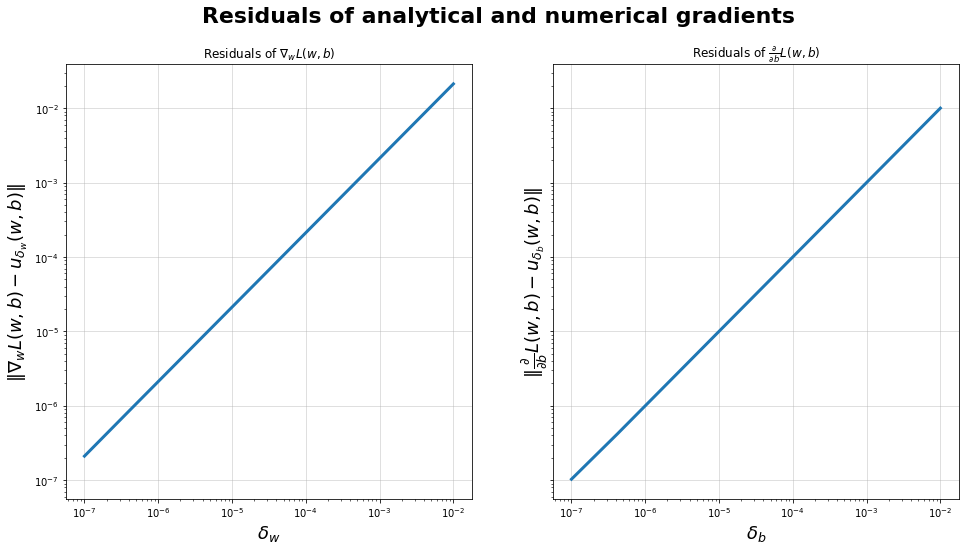

In [100]:
X = [x for x in sub_train.columns if x not in ['VirusScore']]
X_train = sub_train[X]
y_train = sub_train['VirusScore']
compare_gradients(np.array(X_train), np.array(y_train), deltas=np.logspace(-7, -2, 9))

## Q5:

In [101]:

def test_lr(X_train, y_train, X_val, y_val, max_iter = 1500):
    lr_list = np.logspace(-9, -1, 9)

    fig, axs = plt.subplots(3, 3, sharey=True, figsize=(20, 12))
    plt.tight_layout()
    fig.subplots_adjust(hspace=0.5)

    axs = np.ravel(axs)
    for i, lr in enumerate(lr_list):
        cur_linear_reggressor = LinearRegressor(lr)
        train_losses, val_losses = cur_linear_reggressor.fit_with_logs(X_train, y_train, keep_losses=True, X_val=X_val, y_val=y_val, max_iter = max_iter)
        print('lr size = '+str(lr)+', Best train loss = '+str(min(train_losses))+', Best validation loss = '+str(min(val_losses)))

        iterations = np.arange(max_iter + 1)
        axs[i].semilogy(iterations, train_losses, label="Train")
        axs[i].semilogy(iterations, val_losses, label="Validation")
        axs[i].grid(alpha=0.5)
        axs[i].legend()
        axs[i].set_title('lr = '+str(lr))
        axs[i].set_xlabel('iteration')
        axs[i].set_ylabel('MSE')


lr size = 1e-09, Best train loss = [0.10519229], Best validation loss = [0.11162134]
lr size = 1e-08, Best train loss = [0.10518195], Best validation loss = [0.11161086]
lr size = 1e-07, Best train loss = [0.10507862], Best validation loss = [0.11150618]
lr size = 1e-06, Best train loss = [0.10405212], Best validation loss = [0.1104661]
lr size = 1e-05, Best train loss = [0.09443471], Best validation loss = [0.10070782]
lr size = 0.0001, Best train loss = [0.04158443], Best validation loss = [0.04631582]
lr size = 0.001, Best train loss = [0.01801014], Best validation loss = [0.01968823]
lr size = 0.01, Best train loss = [0.01721373], Best validation loss = [0.01876025]
lr size = 0.1, Best train loss = [0.01696156], Best validation loss = [0.01842736]


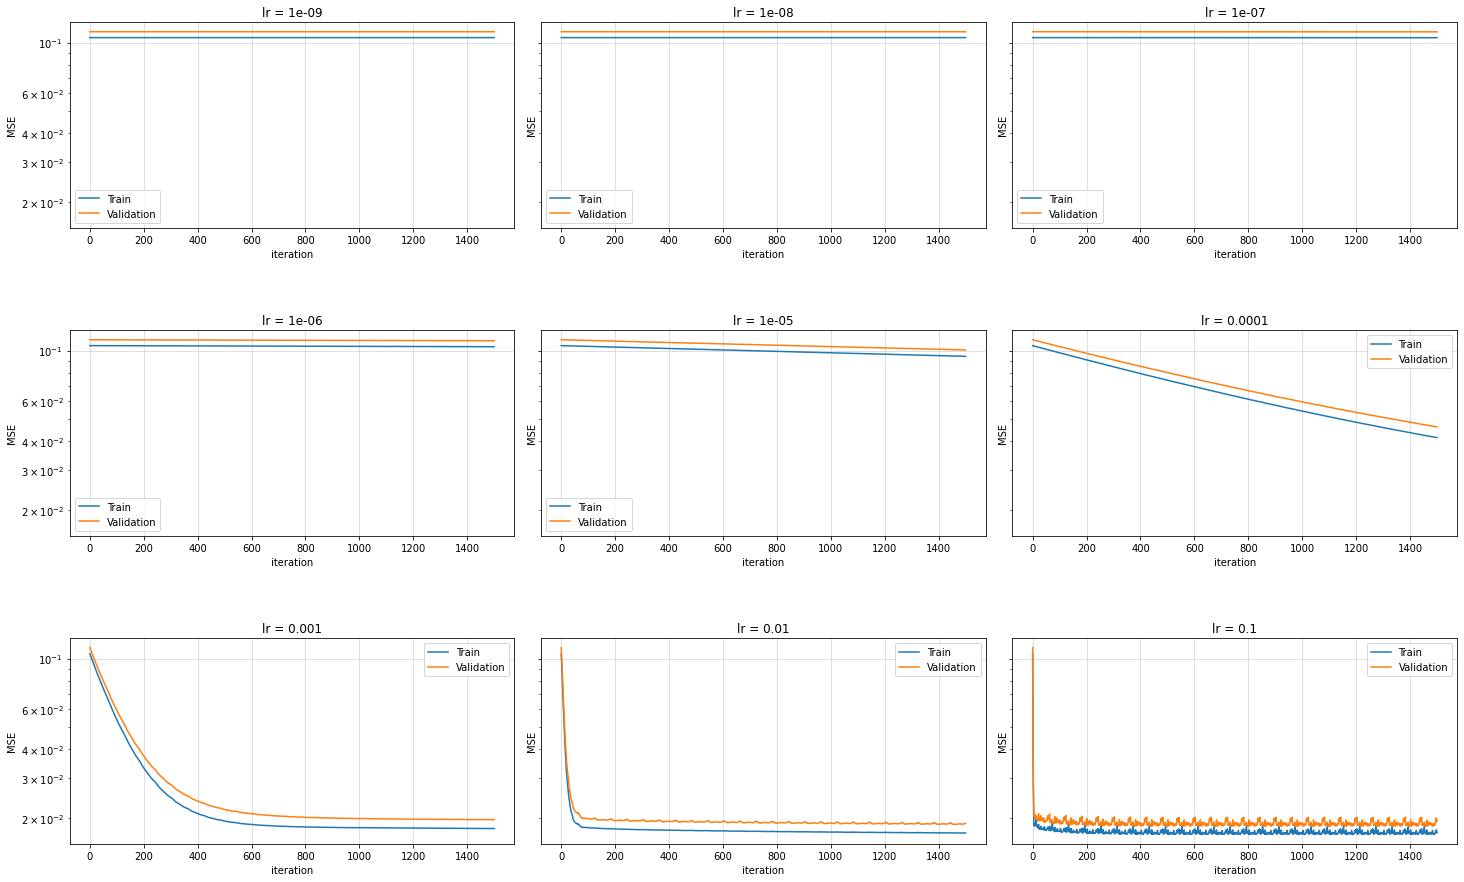

In [102]:

X = [x for x in sub_train.columns if x not in ['VirusScore']]
X_val = sub_val[X]
y_val = sub_val['VirusScore']
test_lr(X_train, y_train, X_val, y_val)


# Section 3:
## Q6:

In [103]:
d_reg = DummyRegressor(strategy="mean")
cv_results = cross_validate(d_reg, X_train, y_train, cv=5, return_train_score=True, scoring="neg_mean_squared_error")
train_acc = -1 * np.mean(cv_results['train_score'])
valid_acc = -1 * np.mean(cv_results['test_score'])

print ("train accuracy: ", train_acc)
print ("valid accuracy: ", valid_acc)

train accuracy:  0.020479304962158204
valid accuracy:  0.02050747821384006


# Section 4:
## Q7:

In [168]:
alphas = np.logspace(0.01, 1, 100)
train_accs = []
valid_accs = []
for alpha in alphas:
    clf = Ridge(alpha = alpha, fit_intercept = True)
    cv_results = cross_validate(clf, X_train, y_train, cv=5, return_train_score=True, scoring="neg_mean_squared_error")
    train_accs.append((alpha, -1 * np.mean(cv_results['train_score'])))
    valid_accs.append((alpha, -1 * np.mean(cv_results['test_score'])))

0


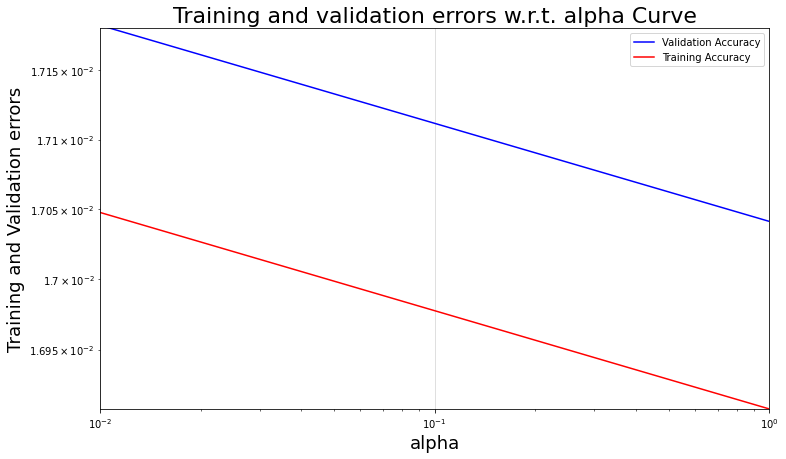

Optimal alpha for training: 0.016907773738950332
Training error for optimal alpha: 0.016907775499193166
Optimal alpha for validation: 0.01704142078348856
Validation error for optimal alpha: 0.017041403032518786


In [178]:
fig = plt.figure(figsize=(12, 7))
ax1 = fig.add_subplot(111)
line1 = ax1.loglog(valid_accs[1], c='b', label='Validation Accuracy')
ax2 = ax1
line2 = ax2.loglog(train_accs[1], c='r', label='Training Accuracy')
ax2.grid(alpha=0.5)
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")
ax1.set_ylabel("Training and Validation errors", fontsize=18)
ax1.set_xlabel("alpha", fontsize=18)
plt.xlim([0.01,1])
min_valid = min(valid_accs[1])
max_valid = max(valid_accs[1])
min_train = min(train_accs[1])
max_train = max(train_accs[1])
min_y_axis=min(min_valid, min_train)
max_y_axis=max(max_valid, max_train)
plt.ylim([min_y_axis,0.01718])
plt.title('Training and validation errors w.r.t. alpha Curve', fontsize=22)
plt.show()

## Q8:

In [ ]:
print(f"Optimal alpha for training: {train_accs[0][train_accs[1].index(min_train)]}")
print(f"Training error for optimal alpha: {min_train}")
print(f"Optimal alpha for validation: {valid_accs[0][valid_accs[1].index(min_valid)]}")
print(f"Validation error for optimal alpha: {min_valid}")